# Neural Network SMS Text Classifier

In this challenge, you need to create a machine learning model that will classify SMS messages as either "ham" or "spam". A "ham" message is a normal message sent by a friend. A "spam" message is an advertisement or a message sent by a company.

You should create a function called  `predict_message`  that takes a message string as an argument and returns a list. The first element in the list should be a number between zero and one that indicates the likeliness of "ham" (0) or "spam" (1). The second element in the list should be the word "ham" or "spam", depending on which is most likely.

For this challenge, you will use the  [SMS Spam Collection](http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/)  dataset. The dataset has already been grouped into train data and test data.

The first two cells import the libraries and data. The final cell tests your model and function. Add your code in between these cells.

# Setup

In [1]:
"""# import libraries
try:
  # %tensorflow_version only exists in Colab.
  %pip install tf-nightly
except Exception:
  pass"""
import tensorflow as tf
import pandas as pd
from tensorflow import keras
# !pip install tensorflow-datasets
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

# my code
%config ZMQInteractiveShell.ast_node_interactivity='last_expr_or_assign'
import string, re

2.13.0


## Download and explore the dataset

In [2]:
# get data files (-nv for not verbose)
!wget -nv https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget -nv https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

2023-10-05 20:29:42 URL:https://cdn.freecodecamp.org/project-data/sms/train-data.tsv [358233/358233] -> "train-data.tsv" [1]
2023-10-05 20:29:42 URL:https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv [118774/118774] -> "valid-data.tsv" [1]


In [3]:
train_file_path = "train-data.tsv"
valid_file_path = "valid-data.tsv"

train_df = pd.read_csv(train_file_path, sep="\t", header=None, names=["label","text"])
valid_df = pd.read_csv(valid_file_path, sep="\t", header=None, names=["label","text"])

raw_train_ds = tf.data.Dataset.from_tensor_slices((train_df['text'], train_df['label']))
raw_valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['text'], valid_df['label']))

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [4]:
# see dataset size
print(raw_train_ds.cardinality(), '\n')

# text, label
for text, label in raw_train_ds.take(5):
  print(text)
  print(label,'\n')

tf.Tensor(4179, shape=(), dtype=int64) 

tf.Tensor(b'ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.', shape=(), dtype=string)
tf.Tensor(b'ham', shape=(), dtype=string) 

tf.Tensor(b'you can never do nothing', shape=(), dtype=string)
tf.Tensor(b'ham', shape=(), dtype=string) 

tf.Tensor(b'now u sound like manky scouse boy steve,like! i is travelling on da bus home.wot has u inmind 4 recreation dis eve?', shape=(), dtype=string)
tf.Tensor(b'ham', shape=(), dtype=string) 

tf.Tensor(b'mum say we wan to go then go... then she can shun bian watch da glass exhibition...', shape=(), dtype=string)
tf.Tensor(b'ham', shape=(), dtype=string) 

tf.Tensor(b'never y lei... i v lazy... got wat? dat day \xc3\xbc send me da url cant work one...', shape=(), dtype=string)
tf.Tensor(b'ham', shape=(), dtype=string) 



In [5]:
# see dataset size
print(raw_valid_ds.cardinality(), '\n')

# text, label
for text, label in raw_valid_ds.take(5):
  print(text)
  print(label,'\n')

tf.Tensor(1392, shape=(), dtype=int64) 

tf.Tensor(b'i am in hospital da. . i will return home in evening', shape=(), dtype=string)
tf.Tensor(b'ham', shape=(), dtype=string) 

tf.Tensor(b"not much, just some textin'. how bout you?", shape=(), dtype=string)
tf.Tensor(b'ham', shape=(), dtype=string) 

tf.Tensor(b"i probably won't eat at all today. i think i'm gonna pop. how was your weekend? did u miss me?", shape=(), dtype=string)
tf.Tensor(b'ham', shape=(), dtype=string) 

tf.Tensor(b'don\xe2\x80\x98t give a flying monkeys wot they think and i certainly don\xe2\x80\x98t mind. any friend of mine and all that!', shape=(), dtype=string)
tf.Tensor(b'ham', shape=(), dtype=string) 

tf.Tensor(b'who are you seeing?', shape=(), dtype=string)
tf.Tensor(b'ham', shape=(), dtype=string) 



## Prepare dataset for training

In [6]:
# Model constants
MAX_FEATURES = 10000 # 10,000 max size of vocabulary for vectorize layer
SEQUENCE_LENGTH = 500 # max pad of each sentence for vectorize layer
EMBEDDING_DIM = 128 # size of embedding space for embedding layer

def custom_standardization(text):
  text = tf.strings.lower(text)
  return tf.strings.regex_replace(text, f"[{re.escape(string.punctuation)}]", "")

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=MAX_FEATURES,
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH,
)

# instantiate StringLookup layer without oov_token
string_layer = tf.keras.layers.StringLookup(
    num_oov_indices=0
)

# make text-only dataset, make label only dataset; call adapt on training sets only
train_text = raw_train_ds.map(lambda x, y: x)
train_label = raw_train_ds.map(lambda x, y: y)

vectorize_layer.adapt(train_text)
string_layer.adapt(train_label)

In [7]:
# use to map raw_train_ds and raw_valid_ds
def vectorize_text_string_label(text, label):
  text = tf.expand_dims(text, -1)
  label = tf.expand_dims(label, -1)
  return vectorize_layer(text), string_layer(label)

In [8]:
# see results of using layer to preprocess text
first_message, first_label = next(iter(raw_train_ds))
print(f"Review: {first_message}")
print(f"Label: {first_label}")
print(f"Vectorized review: {vectorize_text_string_label(first_message, first_label)}")

Review: b'ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.'
Label: b'ham'
Vectorized review: (<tf.Tensor: shape=(1, 500), dtype=int64, numpy=
array([[7632, 2425, 3973,    5,  404,  824,   79,    7, 4156,    3,   47,
          57,    7,  153,   22,    3,  177,   56,  165,   79, 2256,  107,
          26,    3,  302,   23,   43,   13,   16,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 

In [9]:
print(f"1287 ---> {vectorize_layer.get_vocabulary()[5177]}")
print(f" 313 ---> {vectorize_layer.get_vocabulary()[4261]}")
print(f"Vocabulary size: {len(vectorize_layer.get_vocabulary())}")

1287 ---> passport
 313 ---> syria
Vocabulary size: 8181


In [10]:
# vectorize data (turn each sentence into a integer vector)
train_ds = raw_train_ds.map(vectorize_text_string_label)
valid_ds = raw_valid_ds.map(vectorize_text_string_label)

# Do async prefetching / buffering of the data for best performance on GPU
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 500), dtype=tf.int64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [11]:
# see dataset size
print(train_ds.cardinality(), '\n')

# text, label
for text, label in train_ds.take(5):
  print(text)
  print(label,'\n')

tf.Tensor(4179, shape=(), dtype=int64) 

tf.Tensor(
[[7632 2425 3973    5  404  824   79    7 4156    3   47   57    7  153
    22    3  177   56  165   79 2256  107   26    3  302   23   43   13
    16    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 

In [12]:
# see dataset size
print(valid_ds.cardinality(), '\n')

# text, label
for text, label in valid_ds.take(5):
  print(text)
  print(label,'\n')

tf.Tensor(1392, shape=(), dtype=int64) 

tf.Tensor(
[[   3   64    9 1718  102    3   34 1354   88    9  501    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 

## Create model, compile and fit

In [13]:
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1, mode="min")
model_save = tf.keras.callbacks.ModelCheckpoint('best.h5',save_best_only=True)

model = tf.keras.Sequential([
    # input shape (batch_size, input_length); output shape (batch, input_shape (sequence), output_dim (embedding))
    tf.keras.layers.Embedding(input_dim=MAX_FEATURES + 1, output_dim=EMBEDDING_DIM, input_length=SEQUENCE_LENGTH),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280128   
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280257 (4.88 MB)
Trainable params: 1280257 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [14]:
# compile model; any value above 0.0 will be classified as positive (spam)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# build model
EPOCHS = 10
history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=[early_stopping_monitor, model_save])

Epoch 1/10
4179/4179 [==============================] - 43s 9ms/step - loss: 0.3821 - binary_accuracy: 0.8653 - val_loss: 0.3634 - val_binary_accuracy: 0.8657


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
4179/4179 [==============================] - 20s 5ms/step - loss: 0.3000 - binary_accuracy: 0.8732 - val_loss: 0.2486 - val_binary_accuracy: 0.9353
Epoch 3/10
4179/4179 [==============================] - 20s 5ms/step - loss: 0.1656 - binary_accuracy: 0.9399 - val_loss: 0.1361 - val_binary_accuracy: 0.9720
Epoch 4/10
4179/4179 [==============================] - 20s 5ms/step - loss: 0.0986 - binary_accuracy: 0.9710 - val_loss: 0.1059 - val_binary_accuracy: 0.9784
Epoch 5/10
4179/4179 [==============================] - 20s 5ms/step - loss: 0.0738 - binary_accuracy: 0.9797 - val_loss: 0.0917 - val_binary_accuracy: 0.9770
Epoch 6/10
4179/4179 [==============================] - 19s 5ms/step - loss: 0.0613 - binary_accuracy: 0.9832 - val_loss: 0.0886 - val_binary_accuracy: 0.9741
Epoch 7/10
4179/4179 [==============================] - 20s 5ms/step - loss: 0.0554 - binary_accuracy: 0.9844 - val_loss: 0.0692 - val_binary_accuracy: 0.9792
Epoch 8/10
4179/4179 [========================

## Create a plot of accuracy and loss over time

In [15]:
# store model's history
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

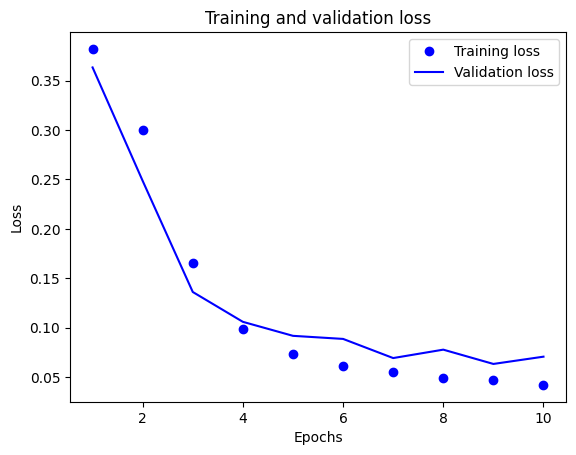

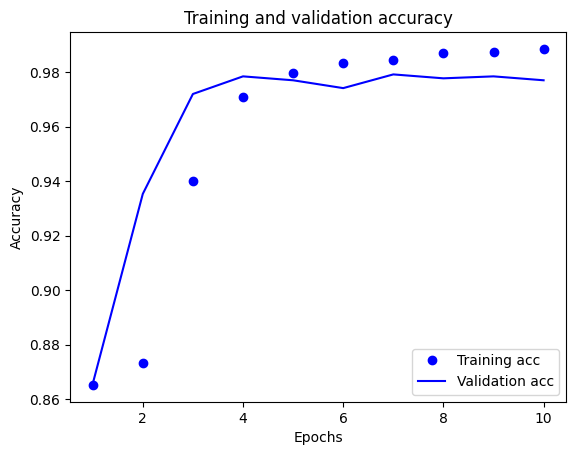

In [16]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model and make inference on new data

In [17]:
# end to end model
export_model = tf.keras.Sequential([
    # can make predictions wihtout this layer but method summary() does not work
    tf.keras.layers.Input(shape=(1,), dtype="string"),
    vectorize_layer,
    model,
    tf.keras.layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

In [18]:
# print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280128   
                                                                 
 dropout (Dropout)           (None, 500, 128)          0         
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280257 (4.88 MB)
Trainable params: 1280257 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [19]:
# print end to end model summary
export_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 sequential (Sequential)     (None, 1)                 1280257   
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 1280257 (4.88 MB)
Trainable params: 1280257 (4.88 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# function to predict messages based on model -> ([0.008318834938108921, 'ham'])
def predict_message(pred_text):
    p = export_model.predict([pred_text])
    return (p[0], ("ham" if p < 0.5 else "spam"))

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 [==============================] - 0s 221ms/step
(array([0.01297196], dtype=float32), 'ham')


In [21]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
    test_messages = [
        "how are you doing today",
        "sale today! to stop texts call 98912460324",
        "i dont want to go. can we try it a different day? available sat",
        "our new mobile video service is live. just install on your phone to start watching.",
        "you have won £1000 cash! call to claim your prize.",
        "i'll bring it tomorrow. don't forget the milk.",
        "wow, is your arm alright. that happened to me one time too",
    ]

    test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
    passed = True

    for msg, ans in zip(test_messages, test_answers):
        prediction = predict_message(msg)
        print(prediction,"\n")
        if prediction[1] != ans:
            passed = False

    if passed:
        print("You passed the challenge. Great job!")
    else:
        print("You haven't passed yet. Keep trying.")


test_predictions()

1/1 [==============================] - 0s 64ms/step
(array([0.01297196], dtype=float32), 'ham') 

1/1 [==============================] - 0s 72ms/step
(array([0.8487727], dtype=float32), 'spam') 

1/1 [==============================] - 0s 56ms/step
(array([0.00490427], dtype=float32), 'ham') 

1/1 [==============================] - 0s 57ms/step
(array([0.9883355], dtype=float32), 'spam') 

1/1 [==============================] - 0s 51ms/step
(array([0.9991536], dtype=float32), 'spam') 

1/1 [==============================] - 0s 39ms/step
(array([0.00412631], dtype=float32), 'ham') 

1/1 [==============================] - 0s 42ms/step
(array([0.01469966], dtype=float32), 'ham') 

You passed the challenge. Great job!
